# Navigation

---

I use this jupyter notebook to train my agents for the project, and to visualize the results. To understand the background of all the introduced algorithms, you can use the Report.md file in this directory.

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.17 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [6]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


In [6]:
%load_ext autoreload
%autoreload 2

from ReplayBuffer import ReplayBuffer, PrioReplayBuffer 
from p1_agent import Agent, PRIOAgent 
import torch 

seed = 0


The dqn() method will be our training algorithm, using the preconfigured hyperparameters, and the agent.
It will stop learning after reaching the 13.0 total reward, which is our goal. 
The maximum length of 1 episode is allowed to be 1000 time units, but i've noticed that the Unity environment always terminates the episode after 300 time steps.  

In [11]:
from collections import deque 

def dqn(n_episodes, max_t, eps_start, eps_end, eps_decay):

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0   
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0] 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), netname)
            break
    return scores


First, let's train an agent using Double DQN: 

In [12]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
EPS_START = 0.1
EPS_END = 0.
EPS_DECAY = 0.98
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate 

memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
agent = Agent(state_size=state_size, action_size=action_size, seed=seed, memory=memory, batch_size=BATCH_SIZE, LR=LR, GAMMA=GAMMA)
netname = "net_ddqn.pth"

scores1 = dqn(5000, 1000, eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY)    


Creating model with  256  and  128  hidden layer sizes.
Creating model with  256  and  128  hidden layer sizes.
Episode 100	Average Score: 0.59
Episode 200	Average Score: 3.77
Episode 300	Average Score: 6.80
Episode 400	Average Score: 8.33
Episode 500	Average Score: 12.92
Episode 502	Average Score: 13.04
Environment solved in 402 episodes!	Average Score: 13.04


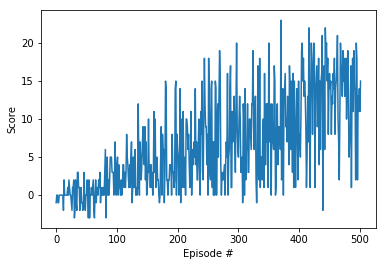

In [13]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores1)), scores1)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Next, train a new network from the scratch with an other agent using Double DQN + Prioritized Experience Replay (with proportional prioritization):

In [16]:
BUFFER_SIZE = int(2e5)  # replay buffer size
BATCH_SIZE = 32         # minibatch size
EPS_START = 0.1
EPS_END = 0.
EPS_DECAY = 0.98
ALPHA = 0.6             # [0~1] convert the importance of TD error to priority
BETA = 0.6              # importance-sampling, from initial value increasing to 1
BETA_INC_PER_SAMPLING = 0.000003
GAMMA = 0.98            # discount factor       # pipa
LR = 5e-4               # learning rate 

memory = PrioReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed, ALPHA, BETA, BETA_INC_PER_SAMPLING)
agent = PRIOAgent(state_size=state_size, action_size=action_size, seed=seed, memory=memory, batch_size=BATCH_SIZE, LR=LR, GAMMA=GAMMA)
netname = "net_prioddqn.pth"

scores2 = dqn(5000, 1000, eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY)    


Creating model with  256  and  128  hidden layer sizes.
Creating model with  256  and  128  hidden layer sizes.
Episode 100	Average Score: 3.30
Episode 200	Average Score: 7.28
Episode 300	Average Score: 10.66
Episode 400	Average Score: 12.24
Episode 433	Average Score: 13.00
Environment solved in 333 episodes!	Average Score: 13.00


Now if you compare the two algorithm, it can be seen that the second one is more efficient in learning to collect bananas: 

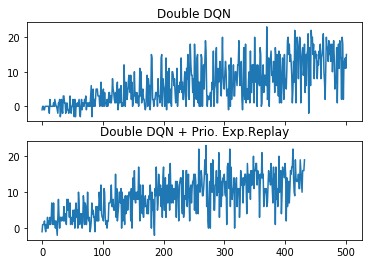

In [35]:
# plot the scores
#fig = plt.figure()
#ax1 = fig.add_subplot(1, 2, 1)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(np.arange(len(scores1)), scores1)
#ax1.ylabel('Score')
#ax1.xlabel('Episode #')
ax1.set_title("Double DQN")
ax2.plot(np.arange(len(scores2)), scores2)
#ax2.ylabel('Score')
#ax2.xlabel('Episode #')
ax2.set_title("Double DQN + Prio. Exp.Replay")
plt.show()

In [ ]:
After these 2 trainings, the final trained neural networks are stored in this directory with the following filenames: 
    - net_ddqn.pth
    - net_prioddqn.pth 
    

In [ ]:
Try to load and play some banana collections using the first network:

In [29]:
# we are in inference mode so the values of the following hyperparameters are ignored
BATCH_SIZE = 0
LR = 0
GAMMA = 0
num_games = 10
max_t = 1000

def play(netname):
    agent = Agent(state_size=state_size, action_size=action_size, seed=seed, memory=None, batch_size=BATCH_SIZE, LR=LR, GAMMA=GAMMA)
    agent.qnetwork_local.load_state_dict(torch.load(netname))
    scores = []

    for i in range(num_games):
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        for t in range(max_t):
            action = agent.act(state, 0.0)                 # select best action, epsilon will be 0 here
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        scores.append(score)
    return ( num_games, scores )


In [30]:
(num_games, scores1) = play( "net_ddqn.pth" )
print("Normal DDQN, Average score of {} games = {}".format( num_games, np.mean(scores1) ) )
(num_games, scores2) = play( "net_prioddqn.pth" )
print("DDQN+Prioritized Experience Learning memory, Average score of {} games = {}".format( num_games, np.mean(scores2) ) )


Creating model with  256  and  128  hidden layer sizes.
Creating model with  256  and  128  hidden layer sizes.
Normal DDQN, Average score of 10 games = 14.3
Creating model with  256  and  128  hidden layer sizes.
Creating model with  256  and  128  hidden layer sizes.
DDQN+Prioritized Experience Learning memory, Average score of 10 games = 12.1


In [40]:
print("DDQN: Avarage score={} Variance={}".format( np.mean(scores1), np.var(scores1) ) )
print("DDQN+PrioExpReplay: Avarage score={} Variance={}".format( np.mean(scores2), np.var(scores2) ) )


DDQN: Avarage score=14.3 Variance=39.81
DDQN+PrioExpReplay: Avarage score=12.1 Variance=6.890000000000001


The average results can be under or over the 13.0 goal with both agents.  
But there is one conclusion when analysing this scores: The first agent's scores' variance is always much higher that the second agent's.
So, the Prioritized Experience learning agent seems to be better: it learned more efficiently, and seems to be producing more robust results.

When finished, we close the environment.

In [36]:
env.close()